In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
import nltk
# nltk.download('wordnet')
# nltk.download('punkt')
import string

data = pd.read_pickle('final cleaned data input without any embedding.pkl')

In [3]:
data

,label,tweet
0,0,"[upset, cant, update, facebook, texting, it, m..."
1,0,"[i, dive, many, time, ball, manage, save, 0, t..."
2,0,"[whole, body, feel, itchy, like, fire]"
3,0,"[no, it, not, behave, all, im, mad, here, i, c..."
4,0,"[not, whole, crew]"
...,...,...
1599994,1,"[just, wake, up, have, no, school, best, feeli..."
1599995,1,"[thewdbcom, very, cool, hear, old, walt, inter..."
1599996,1,"[be, ready, mojo, makeover, ask, detail]"
1599997,1,"[happy, th, birthday, boo, alll, time, tupac, ..."


# BERT (Bidirectional Encoder Representations from Transformers)

In [9]:
data['tweet'] = data['tweet'].astype(str)  # ensure they're strings
data['tweet'] = data['tweet'].str.strip()  # remove whitespace
data = data[data['tweet'].str.len() > 0]   # keep only non-empty tweets

In [15]:
import torch
from transformers import BertTokenizer, BertModel
from tqdm import tqdm

# Load pretrained tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')
bert_model.eval()  # set to evaluation mode

# Optional: move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bert_model.to(device)

# Clean your tweets (make sure they're strings)
data['tweet'] = data['tweet'].astype(str)

# Store embeddings here
tweet_embeddings = []

# Loop through tweets
for tweet in tqdm(data['tweet'], desc="Embedding tweets"):
    # Tokenize the tweet
    inputs = tokenizer(tweet, return_tensors='pt', truncation=True, padding=True, max_length=128)
    inputs = {key: val.to(device) for key, val in inputs.items()}  # move to device

    # Get BERT embeddings
    with torch.no_grad():
        outputs = bert_model(**inputs)
        cls_embedding = outputs.last_hidden_state[:, 0, :]  # [CLS] token embedding
        tweet_embeddings.append(cls_embedding.squeeze().cpu().numpy())

C:\Users\HP-Miko\AppData\Local\Temp\ipykernel_55116\12314225.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['tweet'] = data['tweet'].astype(str)
Embedding tweets:   0%|                                                                    | 0/1595385 [00:00<?, ?it/s]C:\Users\HP-Miko\miniconda3\Lib\site-packages\transformers\models\bert\modeling_bert.py:440: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
Embedding tweets: 100%|████████████████████████████████████████████████████| 1595385/1595385 [5:01:46<00:00, 88.11it/s]


In [17]:
X = np.array(tweet_embeddings)
print("Shape of BERT embeddings:", X.shape)  # e.g., (1000, 768)

Shape of BERT embeddings: (1595385, 768)


In [18]:
y = data['label'].to_numpy()

In [19]:
y

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

# Logistic Regression

Accuracy: 0.6375

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.65      0.64     79461
           1       0.64      0.62      0.63     80078

    accuracy                           0.64    159539
   macro avg       0.64      0.64      0.64    159539
weighted avg       0.64      0.64      0.64    159539



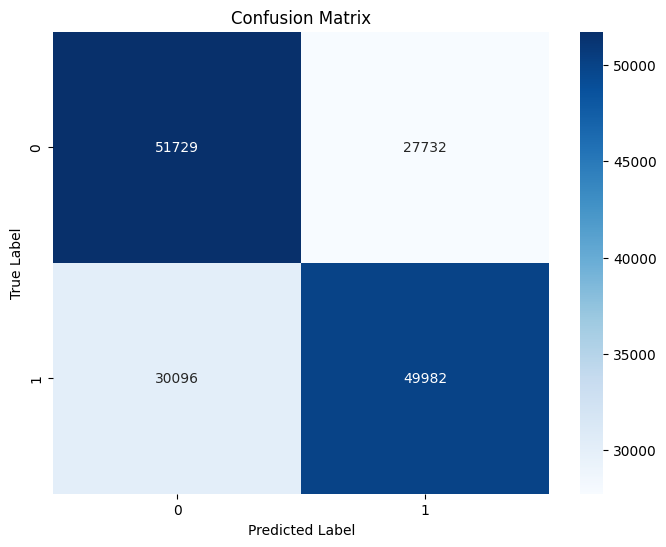

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Split your data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Train the Logistic Regression model
model = LogisticRegression(solver='liblinear', penalty='l2', random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred)) # No need for target_names if you're okay with numerical labels

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted(data['label'].unique()), # Use unique numerical labels for x-axis
            yticklabels=sorted(data['label'].unique())) # Use unique numerical labels for y-axis
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()